### Change DIrectory

In [ ]:
cd "C:/Users/Karpoh/Desktop/Code/DeepLearnAss2"

C:\Users\Karpoh\Desktop\Code\DeepLearnAss2


### Import Library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import os
import numpy as np

from torchsummary import summary
import matplotlib.pyplot as plt

import time

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.models as models

from torchvision.models import resnet18, ResNet18_Weights, ResNet50_Weights

from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR

### Transform and Hyperparameter

In [ ]:
class Train_transform:
  def __init__(self, resize):
    self.transforms = A.Compose([
        A.Resize(resize,resize),
        A.RandomBrightnessContrast(),
        A.RandomFog(),
        A.RandomRain(),
        A.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])
  
  def __call__(self, img):
    return self.transforms(image = np.array(img))['image']

In [ ]:
#Hyperparameter
BATCH_SIZE = 64
EPOCHS = 15
numClasses = 43
lr = 0.0001

#ImageResolution
imgSize = 224

### Read Training Data

In [ ]:
data_path = os.path.join(os.getcwd() , 'Images') 
data = torchvision.datasets.ImageFolder(root=data_path, transform=(Train_transform(imgSize)))

# Split data into train and val sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

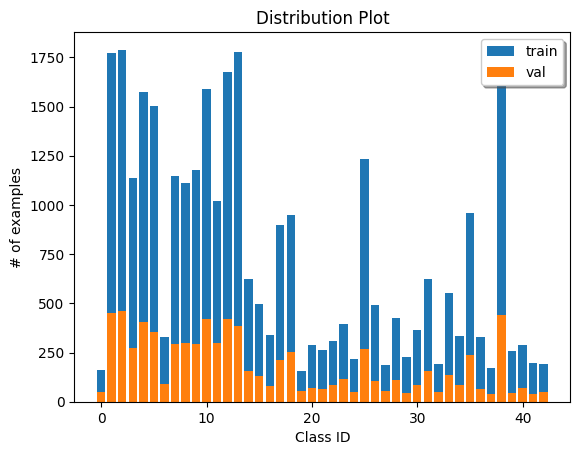

In [ ]:
# Plot histogram for training and validation data

train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*numClasses
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.show()

### Load Pre-Trained Model

In [ ]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 43)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

### Define Training Function

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
# Function to perform training of the model

def train(model, loader, opt, criterion, scheduler=None):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Training pass
        opt.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    # Update learning rate
    if scheduler is not None:
        scheduler.step()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
# Function to perform evaluation on the trained model

def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Run predictions
            output = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

### Training

In [ ]:
# Perform training

# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    
    print("Epoch [%d/%d]: " %(epoch + 1, EPOCHS))
    
    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch [1/15]: 
Training: Loss = 0.5287, Accuracy = 0.8738, Time = 151.72 seconds
Validation: Loss = 0.0837, Accuracy = 0.9785, Time = 28.44 seconds

Epoch [2/15]: 
Training: Loss = 0.0774, Accuracy = 0.9798, Time = 145.05 seconds
Validation: Loss = 0.0630, Accuracy = 0.9834, Time = 27.34 seconds

Epoch [3/15]: 
Training: Loss = 0.0545, Accuracy = 0.9857, Time = 145.45 seconds
Validation: Loss = 0.0453, Accuracy = 0.9868, Time = 26.77 seconds

Epoch [4/15]: 
Training: Loss = 0.0506, Accuracy = 0.9862, Time = 145.44 seconds
Validation: Loss = 0.0439, Accuracy = 0.9869, Time = 26.83 seconds

Epoch [5/15]: 
Training: Loss = 0.0406, Accuracy = 0.9887, Time = 146.26 seconds
Validation: Loss = 0.0424, Accuracy = 0.9869, Time = 26.99 seconds

Epoch [6/15]: 
Training: Loss = 0.0356, Accuracy = 0.9900, Time = 145.20 seconds
Validation: Loss = 0.0454, Accuracy = 0.9859, Time = 27.55 seconds

Epoch [7/15]: 
Training: Loss = 0.0341, Accuracy = 0.9908, Time = 146.84 seconds
Validation: Loss = 0.0418

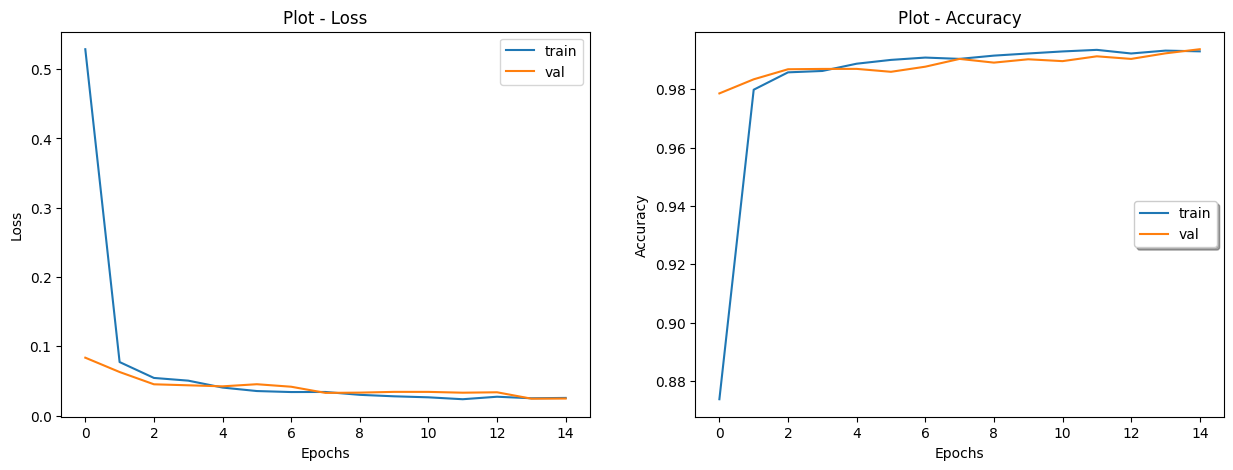

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

In [ ]:
#v3.6(Final) -> (Resnet18, batch=64, lr=0.0001, epochs=15, optimizer=adam, train whole parameter, with albumentation, image = 224)

torch.save(model.state_dict(), 'models/PreTrained_ResNet18_v3.6.pth')

In [ ]:
np.savetxt('ResNet18/ResNet18_Train_Loss.txt', train_loss_list)
np.savetxt('ResNet18/ResNet18_Train_Acc.txt', train_acc_list)
np.savetxt('ResNet18/ResNet18_Val_Loss.txt', val_loss_list)
np.savetxt('ResNet18/ResNet18_Val_Acc.txt', val_acc_list)